Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


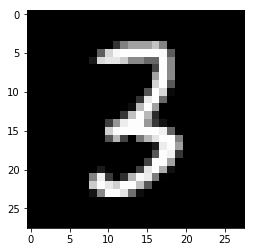

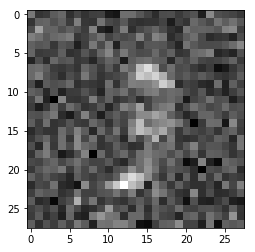

Iteration: 0  ls: 178.53 mean_ils: 178.53 mean_dls: 0.00


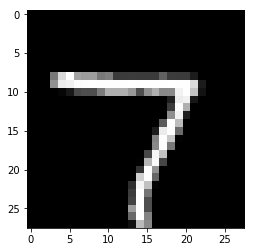

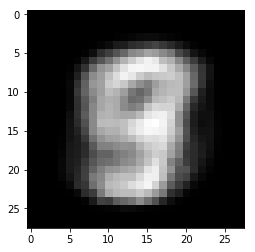

Iteration: 200  ls: 50.79 mean_ils: 49.36 mean_dls: 1.43
7
7
5
2


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import random

# =========
# Get rid of warnings
# =========

import logging
class WarningFilter(logging.Filter):
    def filter(self, record):
        msg = record.getMessage()
        tf_warning = '(from tensorflow.contrib.learn.python.learn.' in msg
        return not tf_warning

logger = logging.getLogger('tensorflow')
logger.addFilter(WarningFilter())
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'


# =========
# Loading the training data
# =========

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data')

# =========
# Defining input and output data
# =========

tf.reset_default_graph()

batch_size = 64

X_in = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28], name='X')
Y    = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28], name='Y')
Y_flat = tf.reshape(Y, shape=[-1, 28 * 28])
keep_prob = tf.placeholder(dtype=tf.float32, shape=(), name='keep_prob')

dec_in_channels = 1
n_latent = 8

reshaped_dim = [-1, 7, 7, dec_in_channels]
inputs_decoder = 49 * dec_in_channels // 2


def lrelu(x, alpha=0.3):
    return tf.maximum(x, tf.multiply(x, alpha))


# =========
# Defining the encoder
# =========

def encoder(X_in, keep_prob):
    activation = lrelu
    with tf.variable_scope("encoder", reuse=tf.AUTO_REUSE):
        X = tf.reshape(X_in, shape=[-1, 28, 28, 1])
        x = tf.layers.conv2d(X, filters=64, kernel_size=4, strides=2, padding='same', activation=activation)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.conv2d(x, filters=64, kernel_size=4, strides=2, padding='same', activation=activation)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.conv2d(x, filters=64, kernel_size=4, strides=1, padding='same', activation=activation)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.contrib.layers.flatten(x)
        mn = tf.layers.dense(x, units=n_latent)
        sd       = 0.5 * tf.layers.dense(x, units=n_latent)            
        epsilon = tf.random_normal(tf.stack([tf.shape(x)[0], n_latent])) 
        z  = mn + tf.multiply(epsilon, tf.exp(sd))
        
        return z, mn, sd

    
# =========
# Defining the decoder
# =========

def decoder(sampled_z, keep_prob):
    with tf.variable_scope("decoder", reuse=tf.AUTO_REUSE):
        x = tf.layers.dense(sampled_z, units=inputs_decoder, activation=lrelu)
        x = tf.layers.dense(x, units=inputs_decoder * 2 + 1, activation=lrelu)
        x = tf.reshape(x, reshaped_dim)
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=2, padding='same', activation=tf.nn.relu)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=1, padding='same', activation=tf.nn.relu)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=1, padding='same', activation=tf.nn.relu)
        
        x = tf.contrib.layers.flatten(x)
        x = tf.layers.dense(x, units=28*28, activation=tf.nn.sigmoid)
        img = tf.reshape(x, shape=[-1, 28, 28])
        return img


# =========
# Put Together
# =========

sampled, mn, sd = encoder(X_in, keep_prob)
dec = decoder(sampled, keep_prob)


# =========
# Computing losses and enforcing a Gaussian latent distribution
# =========

unreshaped = tf.reshape(dec, [-1, 28*28])
img_loss = tf.reduce_sum(tf.squared_difference(unreshaped, Y_flat), 1)
latent_loss = -0.5 * tf.reduce_sum(1.0 + 2.0 * sd - tf.square(mn) - tf.exp(2.0 * sd), 1)
loss = tf.reduce_mean(img_loss + latent_loss)
optimizer = tf.train.AdamOptimizer(0.0005).minimize(loss)
sess = tf.Session()
sess.run(tf.global_variables_initializer())


# =========
# Training the network
# =========

for i in range(300):
    batch = [np.reshape(b, [28, 28]) for b in mnist.train.next_batch(batch_size=batch_size)[0]]
    sess.run(optimizer, feed_dict = {X_in: batch, Y: batch, keep_prob: 0.8})
    if not i % 200:
        ls, d, i_ls, d_ls, mu, sigm = sess.run([loss, dec, img_loss, latent_loss, mn, sd], feed_dict = {X_in: batch, Y: batch, keep_prob: 1.0})
        plt.imshow(np.reshape(batch[0], [28, 28]), cmap='gray')
        plt.show()
        plt.imshow(d[0], cmap='gray')
        plt.show()
        print('Iteration: %d  ls: %2.2f mean_ils: %2.2f mean_dls: %2.2f' %
              ( i,ls,np.mean(i_ls),np.mean(d_ls) )   )



# =========
# Generating new data
# =========

randoms = [np.random.normal(0, 1, n_latent) for _ in range(10)]
imgs = sess.run(dec, feed_dict = {sampled: randoms, keep_prob: 1.0})
imgs = [np.reshape(imgs[i], [28, 28]) for i in range(len(imgs))]

for img in imgs:
    plt.figure(figsize=(1,1))
    plt.axis('off')
    plt.imshow(img, cmap='gray')



# =========
# get ten random pairs index of same digit image e.g. [1,1,2,2,3,3...] 
# =========
test_image = mnist.test.images
test_label = mnist.test.labels

sess = tf.Session()  # establish session
init = tf.global_variables_initializer()
sess.run(init)

# =========
# generate 10 interpoliation points
# =========
def interpolate(sample1, sample2):
    resultSamples = [sample1]
    diff = (sample2 - sample1) / 8  # may pay attention
    sample = sample1
    for i in range(7):
        sample = sample + diff
        sample_copy = sample.copy()
        resultSamples.append(sample_copy)
    resultSamples.append(sample2)
    return resultSamples

def generateTenRandomPairs(images,labels):
    enc, mn, sd = encoder(X_in, keep_prob)  # define encoder layer
    resultArr = [];
    for i in range(0,10):
        randomPair = random.randint(0,9)
        sameDigitArr = np.where(labels == randomPair)[0]
        numberOneIdx = random.randint(0,len(sameDigitArr)-1)
        numberOneImg = sameDigitArr[numberOneIdx]
        numberTwoIdx = random.randint(0,len(sameDigitArr)-1)
        numberTwoImg = sameDigitArr[numberOneIdx]
        resultArr.append(numberOneImg)
        resultArr.append(numberTwoImg)
        sample1 = np.reshape(test_image[numberOneIdx], [1, 28, 28])
        sample2 = np.reshape(test_image[numberTwoIdx], [1, 28, 28])
        one, mn1, sd1 = sess.run([enc, mn, sd], feed_dict = {X_in: sample1, keep_prob: 1.0})
        two, mn2, sd2 = sess.run([enc, mn, sd], feed_dict = {X_in: sample2, keep_prob: 1.0})
        interpolate(one, two)
        
    return resultArr;
    
    
pairRandArr = generateTenRandomPairs(test_image,test_label)
print(test_label[pairRandArr[0]])
print(test_label[pairRandArr[1]])

# =========
# get ten pairs index of diff digit image e.g. [1,1,2,2,3,3...] 
# =========

def generateTenDiffPairs(images,labels):
    resultArr = [];
    for i in range(0,10):
        randomOne = random.randint(0,9)
        sameDigitArr = np.where(labels == randomOne)[0]
        numberOneIdx = random.randint(0,len(sameDigitArr)-1)
        numberOneImg = sameDigitArr[numberOneIdx]
        
        randomTwo = random.randint(0,9)
        while randomTwo == randomOne:
            randomTwo = random.randint(0,9)
        sameDigitArr = np.where(labels == randomTwo)[0]
        numberTwoIdx = random.randint(0,len(sameDigitArr)-1)
        numberTwoImg = sameDigitArr[numberTwoIdx]
        resultArr.append(numberOneImg)
        resultArr.append(numberTwoImg)
    return resultArr;

pairArr = generateTenDiffPairs(test_image,test_label)
print(test_label[pairArr[4]])
print(test_label[pairArr[5]])



